In [1]:
! pip uninstall transformers -y -q
! pip install transformers[torch] -q
! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [5]:
df = pd.read_csv('/content/Restaurant reviews.csv')

In [6]:
df = df[["Review" , "Rating"]]

In [7]:
df = df.dropna()

In [8]:
df.head()

,Review,Rating
0,"The ambience was good, food was quite good . h...",5
1,Ambience is too good for a pleasant evening. S...,5
2,A must try.. great food great ambience. Thnx f...,5
3,Soumen das and Arun was a great guy. Only beca...,5
4,Food is good.we ordered Kodi drumsticks and ba...,5


In [9]:
df.describe()

,Review,Rating
count,9955,9955
unique,9364,10
top,good,5
freq,237,3826


In [10]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9955 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  9955 non-null   object
 1   Rating  9955 non-null   object
dtypes: object(2)
memory usage: 233.3+ KB
None


<Axes: xlabel='Rating', ylabel='count'>

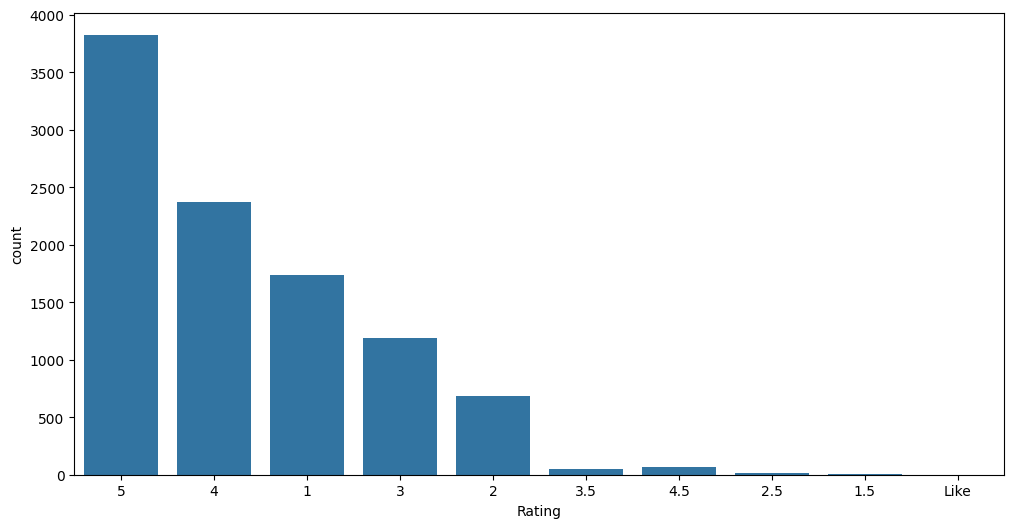

In [11]:
plt.figure(figsize=(12,6))
sns.countplot(x='Rating',data=df)

In [12]:
df = df[df['Rating'].isin(['1', '5'])]

In [13]:
df['Rating'].value_counts()

Rating
5    3826
1    1735
Name: count, dtype: int64

In [14]:
def sample_by_senimwnt(df, sample_size=1200):
  sampled_df = pd.DataFrame()
  for value in df['Rating'].unique():
    subset = df[df['Rating'] == value]
    if len(subset) >= sample_size:
      sampled_df = pd.concat([sampled_df, subset.sample(sample_size)], ignore_index=True)
    else:
      sampled_df = pd.concat([sampled_df, subset], ignore_index=True)  # Include all rows if less than sample size

  return sampled_df

In [15]:
df = sample_by_senimwnt(df)

In [16]:
df.shape

(2400, 2)

In [17]:
df['Review'][0], df['Rating'][0]

('Mr. Faraan, Mr. Llima, Mrs, Piyali, is awexome and I love the way this people behave and awesome I prefer again to this place It is an awexome place to visit actually I think to live here again next time I visit.. ;)',
 '5')

In [18]:
df['sentiment'] = df['Rating'].replace({'5': 1, '1': 0})
df = df.drop('Rating',axis=1)
df.head()

,Review,sentiment
0,"Mr. Faraan, Mr. Llima, Mrs, Piyali, is awexome...",1
1,Nice place awesome ambience food was really go...,1
2,The ambience is nothing but awesome. Even on a...,1
3,Pizza was lil burnt,1
4,"Extraordinary , fantastic , marvellous ..........",1


In [19]:
df.head()

,Review,sentiment
0,"Mr. Faraan, Mr. Llima, Mrs, Piyali, is awexome...",1
1,Nice place awesome ambience food was really go...,1
2,The ambience is nothing but awesome. Even on a...,1
3,Pizza was lil burnt,1
4,"Extraordinary , fantastic , marvellous ..........",1


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Review'],df['sentiment'],test_size=0.2)

len(X_train), len(X_test)

(1920, 480)

In [21]:
X_train, X_test, y_train, y_test = list(X_train), list(X_test), list(y_train), list(y_test)
X_train[:2], y_train[:2]

(['One of the best place to have biryani in gachibowli.\nBiryani is best here. Service is good.\nGood thing is you can get 1+1 on food here. Enjoy the great food',
  'Had good experience here with a new concept of serving food and making your own pizza. Service from Mr.Avinash is superb and overwhelmed to have been attended who served us food till we were full and content.'],
 [1, 1])

In [22]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

# Setting device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [23]:
class data(Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, index):
    item = {key: torch.tensor(val[index]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[index])
    return item

  def __len__(self):
    return len(self.labels)

In [24]:
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name,model_max_length=512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [25]:
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)

train_dataset = data(train_encoding, y_train)
test_dataset = data(test_encoding, y_test)

In [26]:
training_args = TrainingArguments(
  output_dir='./results',            # Directory where model checkpoints & results will be saved
  num_train_epochs=2,                # No of training epochs
  per_device_train_batch_size=32,    # Batch size for training per device
  per_device_eval_batch_size=32,     # Batch size for evaluation per device
  learning_rate=2e-05,               # Learning rate for optimizer
  warmup_steps=500,                  # No of warmup steps for the learning rate scheduler
  weight_decay=0.01,                 # Weight decay coefficient for regularization
  logging_dir='./logs',              # Directory for logging training information
  load_best_model_at_end=True,       # Whether to load the best model from checkpoints at the end of training
  logging_steps=200,                 # Log training metrics every `logging_steps` steps
  save_steps=400,                    # Save model checkpoints every `save_steps` steps
  evaluation_strategy="steps",       # Evaluate on the evaluation dataset every `logging_steps` steps
)

In [27]:
model = DistilBertForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=train_dataset,
                  eval_dataset=test_dataset)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
from accelerate import Accelerator

# Initialize Accelerator and Trainer
Accelerator()
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=120, training_loss=0.6188489278157552, metrics={'train_runtime': 165.5746, 'train_samples_per_second': 23.192, 'train_steps_per_second': 0.725, 'total_flos': 508674810839040.0, 'train_loss': 0.6188489278157552, 'epoch': 2.0})

In [29]:
def predict_sentiment(model, tokenizer, text, device):
    if torch.cuda.is_available() and device == 'cuda':
        model.to('cuda')
    tokenized = tokenizer(text, truncation=True, padding=True, return_tensors='pt').to(device)
    outputs = model(**tokenized)
    probs = F.softmax(outputs.logits, dim=-1)
    preds = torch.argmax(outputs.logits, dim=-1).item()
    probs_max = probs.max().detach().cpu().numpy()
    prediction = "Positive" if preds == 1 else "Negative"
    print(f'{text}\nSentiment: {prediction}\tProbability: {probs_max*100:.2f}%\n', end="-"*50 + "\n")

In [34]:
text = 'Impeccable service, luxurious amenities, and breathtaking views. The epitome of comfort and relaxation. A truly unforgettable stay'
predict_sentiment(model, tokenizer, text, device)

Impeccable service, luxurious amenities, and breathtaking views. The epitome of comfort and relaxation. A truly unforgettable stay
Sentiment: Positive	Probability: 81.43%
--------------------------------------------------


In [35]:
text = 'Disappointed by cleanliness standards, noisy surroundings, and subpar amenities. Not worth the price for the experience provided.'
predict_sentiment(model, tokenizer, text, device)

Disappointed by cleanliness standards, noisy surroundings, and subpar amenities. Not worth the price for the experience provided.
Sentiment: Negative	Probability: 67.54%
--------------------------------------------------


In [ ]:
bert_model_dir = "bert_finetuned"

In [ ]:
trainer.save_model("bert_model_dir")
tokenizer.save_pretrained("bert_model_dir")

In [ ]:
tokenizer2 = DistilBertTokenizerFast.from_pretrained("bert_finetuned",model_max_length=512)
model2 = DistilBertForSequenceClassification.from_pretrained("bert_finetuned")